In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from PIL import Image


In [2]:
traindir = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\train"
testdir = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\test"
validdir = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\val"


In [3]:
# Function to load RGB images from a folder with labels inferred from subdirectories
def load_images(folder):
    images = []
    targets = []
    class_folders = os.listdir(folder)
    for class_folder in class_folders:
        class_path = os.path.join(folder, class_folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory entries
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if not os.path.isfile(img_path):
                continue  # Skip non-file entries
            img = Image.open(img_path).convert('RGB')  # Keep RGB format
            img = img.resize((128, 128))
            img_array = np.array(img)
            images.append(img_array)

            # Extract target label from parent folder name (class name)
            target = class_folder
            targets.append(target)
    return np.array(images), np.array(targets)

In [4]:
# Load training, validation, and test data
input_train, target_train = load_images(traindir)
input_valid, target_valid = load_images(validdir)
input_test, target_test = load_images(testdir)

In [5]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], 128, 128, 3)  # Use 3 channels
input_valid = input_valid.reshape(input_valid.shape[0], 128, 128, 3)  # Use 3 channels
input_test = input_test.reshape(input_test.shape[0], 128, 128, 3)  # Use 3 channels
input_shape = (128, 128, 3)  # Adjust input shape for RGB images

In [6]:
input_train = input_train.astype('float32')
input_valid = input_valid.astype('float32')
input_test = input_test.astype('float32')

In [7]:
# Convert into [0, 1] range
input_train = input_train / 255
input_valid = input_valid / 255
input_test = input_test / 255

In [8]:
# Create a dictionary to map string labels to numeric values
label_to_index = {label: index for index, label in enumerate(np.unique(target_train))}

In [9]:
# Print the label-to-index mapping
print("Label to Index Mapping:")
for label, index in label_to_index.items():
    print(f"Label: {label} -> Index: {index}")

Label to Index Mapping:
Label: Apple___Apple_scab -> Index: 0
Label: Apple___Black_rot -> Index: 1
Label: Apple___Cedar_apple_rust -> Index: 2
Label: Apple___healthy -> Index: 3
Label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot -> Index: 4
Label: Corn_(maize)___Common_rust_ -> Index: 5
Label: Corn_(maize)___Northern_Leaf_Blight -> Index: 6
Label: Corn_(maize)___healthy -> Index: 7
Label: Grape___Black_rot -> Index: 8
Label: Grape___Esca_(Black_Measles) -> Index: 9
Label: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) -> Index: 10
Label: Grape___healthy -> Index: 11
Label: Tomato___Bacterial_spot -> Index: 12
Label: Tomato___Early_blight -> Index: 13
Label: Tomato___Late_blight -> Index: 14
Label: Tomato___healthy -> Index: 15


In [10]:
# Convert string labels to numeric values using label_to_index mapping
target_train_indices = np.array([label_to_index[label] for label in target_train])
target_test_indices = np.array([label_to_index[label] for label in target_test])
target_valid_indices = np.array([label_to_index[label] for label in target_valid])

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
# Convert numeric labels to categorical targets
target_train_categorical = to_categorical(target_train_indices, num_classes=16)
target_valid_categorical = to_categorical(target_valid_indices, num_classes=16)
target_test_categorical = to_categorical(target_test_indices, num_classes=16)

In [13]:
# Print the shape of data and targets after preprocessing
print("Input shape (train):", input_train.shape)
print("Input shape (validation):", input_valid.shape)
print("Input shape (test):", input_test.shape)
print("Target shape (train):", target_train_categorical.shape)
print("Target shape (validation):", target_valid_categorical.shape)
print("Target shape (test):", target_test_categorical.shape)

Input shape (train): (22488, 128, 128, 3)
Input shape (validation): (6425, 128, 128, 3)
Input shape (test): (3214, 128, 128, 3)
Target shape (train): (22488, 16)
Target shape (validation): (6425, 16)
Target shape (test): (3214, 16)


In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load the InceptionV3 model, excluding the top layers
inception_base = InceptionV3(include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers so they won't be updated during training
inception_base.trainable = False

# Build the classifier on top of the base model
inception_classifier = Sequential()
inception_classifier.add(inception_base)
inception_classifier.add(Flatten())
inception_classifier.add(Dropout(0.2))  # Add dropout layer with 0.2 dropout rate
inception_classifier.add(Dense(16, activation='softmax'))

# Print the model summary to review the architecture
inception_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                131088    
Total params: 21,933,872
Trainable params: 131,088
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
# Compile the model
inception_classifier.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])


In [19]:
# Data augmentation setup
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(input_train, target_train_categorical, batch_size=32)
valid_generator = valid_datagen.flow(input_valid, target_valid_categorical, batch_size=32)


In [20]:
# Train the InceptionV3 model
history_inception = inception_classifier.fit(
    train_generator,
    steps_per_epoch=len(input_train) // 32,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=len(input_valid) // 32
)

Epoch 1/20
702/702 [==============================] - 453s 645ms/step - loss: 1.8239 - accuracy: 0.6613 - val_loss: 1.1513 - val_accuracy: 0.7734
Epoch 2/20
702/702 [==============================] - 412s 587ms/step - loss: 1.6897 - accuracy: 0.7390 - val_loss: 1.0467 - val_accuracy: 0.8130
Epoch 3/20
702/702 [==============================] - 414s 590ms/step - loss: 1.7846 - accuracy: 0.7586 - val_loss: 1.1497 - val_accuracy: 0.8216
Epoch 4/20
702/702 [==============================] - 415s 591ms/step - loss: 1.7725 - accuracy: 0.7701 - val_loss: 1.4281 - val_accuracy: 0.8044
Epoch 5/20
702/702 [==============================] - 413s 589ms/step - loss: 1.9174 - accuracy: 0.7717 - val_loss: 1.3370 - val_accuracy: 0.8306
Epoch 6/20
702/702 [==============================] - 417s 594ms/step - loss: 1.8192 - accuracy: 0.7850 - val_loss: 1.4601 - val_accuracy: 0.8259
Epoch 7/20
702/702 [==============================] - 412s 587ms/step - loss: 1.9183 - accuracy: 0.7850 - val_loss: 1.1163 -

In [21]:
# Evaluate the model on test data
test_loss, test_accuracy = inception_classifier.evaluate(input_test, target_test_categorical)

# Print test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on a different dataset (e.g., validation data)
val_loss, val_accuracy = inception_classifier.evaluate(input_valid, target_valid_categorical)

# Print validation loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


import numpy as np

# Predict the classes for the test set
predictions = inception_classifier.predict(input_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(target_test_categorical, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)

# Print the accuracy
print("Calculated Accuracy:", accuracy)

101/101 [==============================] - 39s 388ms/step - loss: 1.1394 - accuracy: 0.8793
Test Loss: 1.1394391059875488
Test Accuracy: 0.8792781829833984
201/201 [==============================] - 82s 406ms/step - loss: 1.2267 - accuracy: 0.8742
Validation Loss: 1.226737380027771
Validation Accuracy: 0.8742412328720093
Calculated Accuracy: 0.8792781580584941


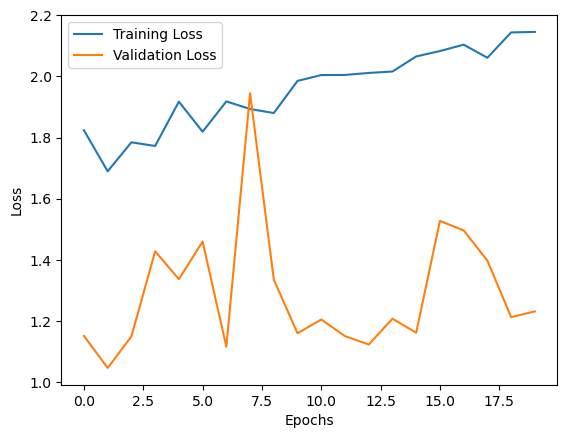

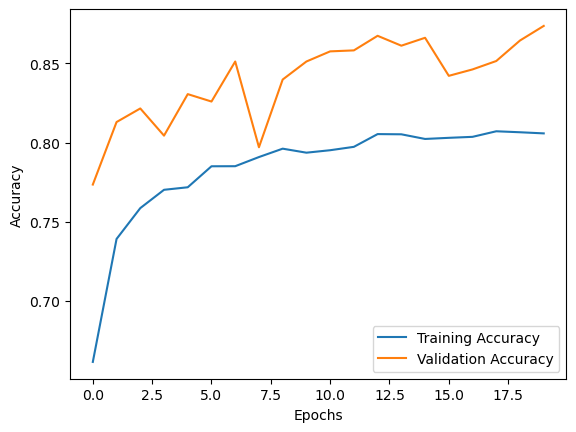

In [22]:
# Optionally, visualize training history
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report

# Make predictions on test data
predictions = inception_classifier.predict(input_test)

# Convert predictions from one-hot encoded format to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels from one-hot encoded format to class labels
true_classes = np.argmax(target_test_categorical, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       200
           1       0.85      0.95      0.90       200
           2       0.90      0.95      0.92       200
           3       0.92      0.89      0.90       200
           4       0.86      0.79      0.82       200
           5       0.94      0.99      0.97       200
           6       0.80      0.81      0.81       200
           7       0.97      0.97      0.97       200
           8       0.90      0.67      0.77       200
           9       0.84      0.93      0.88       200
          10       0.94      0.98      0.96       200
          11       0.87      0.98      0.92       200
          12       0.85      0.88      0.86       214
          13       0.83      0.61      0.70       200
          14       0.83      0.83      0.83       200
          15       0.92      0.95      0.93       200

    accuracy                           0.88      3214
   

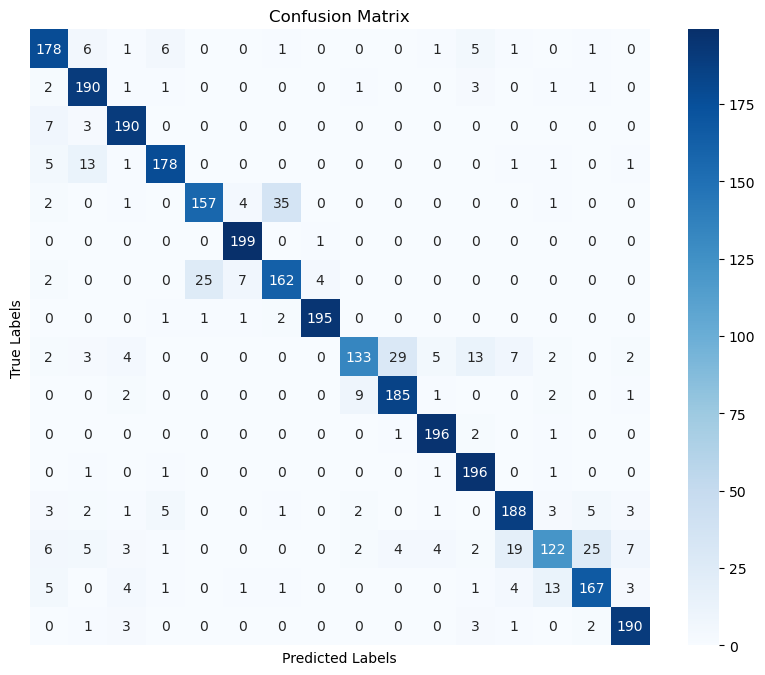

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
classes = []  # Replace with your class names

# Get the true class labels for the test set
true_labels = [label_to_index[label] for label in target_test]

# Get the predicted class labels for the test set
predicted_labels = [np.argmax(prediction) for prediction in inception_classifier.predict(input_test)]

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

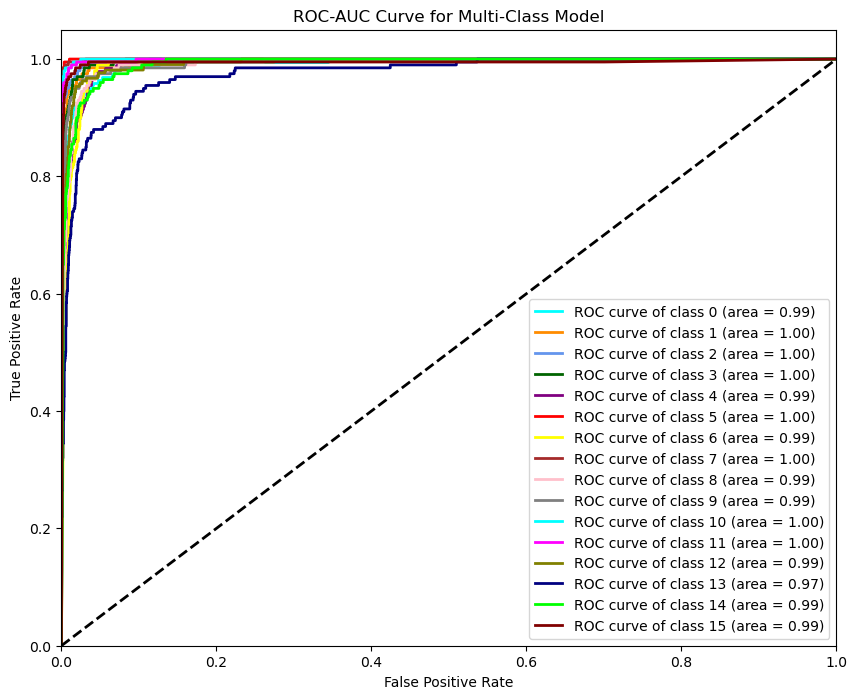

In [25]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get predictions for the test set
y_pred = inception_classifier.predict(input_test)

# Binarize the labels for ROC calculation
y_test_binarized = label_binarize(target_test_indices, classes=np.arange(16))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(16):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'red', 'yellow', 'brown', 'pink', 'grey', 'cyan', 'magenta', 'olive', 'navy', 'lime', 'maroon'])
for i, color in zip(range(16), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-Class Model')
plt.legend(loc="lower right")
plt.show()

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to your saved model and dataset
model_path = r"H:\Thesis\Thesis work Version 7\Result_V_7\Thesis_Demo_Simulation_6(With 16 Class) Best Result.h5"
train_folder = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\train"
test_folder = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\test"
img_height, img_width = 256, 256  # Update as per your model input size

# Load the model
model = load_model(model_path)

# Prepare data generators
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict on test and train data
y_test_true = test_generator.classes
y_train_true = train_generator.classes

y_test_pred = model.predict(test_generator)
y_train_pred = model.predict(train_generator)

# Convert predictions to class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=-1)
y_train_pred_classes = np.argmax(y_train_pred, axis=-1)

# Calculate MSE
test_mse = mean_squared_error(y_test_true, y_test_pred_classes)
train_mse = mean_squared_error(y_train_true, y_train_pred_classes)

# Calculate Bias and Variance (approximated)
# For Bias: Mean of the differences between the mean of the predictions and the true labels
bias_test = np.mean(np.abs(np.mean(y_test_pred_classes) - y_test_true))
bias_train = np.mean(np.abs(np.mean(y_train_pred_classes) - y_train_true))

# For Variance: Variance of the predictions
variance_test = np.var(y_test_pred_classes)
variance_train = np.var(y_train_pred_classes)

# Print results
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Test Bias: {bias_test}')
print(f'Train Bias: {bias_train}')
print(f'Test Variance: {variance_test}')
print(f'Train Variance: {variance_train}')



ValueError: ('Unrecognized keyword arguments:', dict_keys(['batch_shape']))